# Avance 2. Ingeniería de Características

### Integrantes:

- **A01794940** José de Jesús Peña Rodríguez.  
- **A01283104** Kevin Dueñas Aguirre.  
- **A01794191** Juan Antonio Chiñas Mata.


In [142]:
import os
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Reading CSV file from local route

In [143]:
warnings.filterwarnings("ignore")
def read_csv(dataset_path):
    current_path = os.getcwd()
    aux_curr_path = current_path
    project_path = aux_curr_path.replace('/notebooks', '')
    dataset_path = os.path.join(project_path, dataset_path)
    return dataset_path

In [144]:
CSV_PATH = "dataset/Datos_Imgenes.csv"
df = pd.read_csv(read_csv(CSV_PATH))

## Data Preprocessing  
Based on a preliminary session with our tutor, we identified several columns that either lacked relevant information or contained redundant data already present in other columns. Consequently, we decided to remove the following columns:  

- `index`  
- `date`  
- `page`  
- `TotalPages`  
- `ModelApplied`  
- `Details`  
- `ModelReported`  

## Project Objective  
For this project, it was explicitly required to develop a solution and analysis to identify groups of documents acquired by different machine learning models.  

### Machine Learning Models  
The models involved in this process are:  

- `Model`  
- `Estado_cuenta`  
- `Recibo_nomina`  
- `INE`  
- `Comprobante_domicilio`  
- `Carta_libranza`

In [145]:
columns_to_delete = ["Index", "Date", "Page", "TotalPages","ModelApplied", "Details","ModelReported"]
updated_df = df.drop(columns=columns_to_delete, axis=1)


In [146]:
updated_df.head(10)

,Model,ClassId,PagesProcessed,Fields,EmptyFields,ConfR,ConfA,ConfW,Sharpness,Contrast,Clarity,Resolution,DocType
0,comprobante_domicilio,NaN,1,12,0,0.981,0.674,0.889,64.0,38.0,2523.0,263.0,CFE
1,recibo_nomina,NaN,1,15,0,0.948,0.931,0.943,399.0,42.0,17045.0,672.0,IMSS
2,recibo_nomina,NaN,1,15,3,0.941,0.837,0.910,166.0,29.0,4866.0,233.0,IMSS
3,ine,NaN,1,38,11,0.914,0.925,0.917,157.0,38.0,6140.0,356.0,INE
4,estado_cuenta,TXN,2,27,1,0.914,0.934,0.920,262.0,36.0,9512.0,479.0,EC
5,estado_cuenta,TXN,2,27,1,0.914,0.934,0.920,273.0,35.0,9706.0,491.0,EC
6,carta_libranza,NaN,1,19,0,0.993,0.975,0.987,1137.0,51.0,58551.0,376.0,CLIB
7,ine,NaN,1,38,11,0.849,0.873,0.856,174.0,41.0,7275.0,394.0,INE
8,carta_libranza,NaN,1,19,0,0.993,0.975,0.988,1137.0,51.0,58551.0,376.0,CLIB
9,ine,NaN,1,38,11,0.849,0.873,0.856,174.0,41.0,7275.0,394.0,INE


# Creating a filter on Model column 

## Data Filtering and Preparation  

In the following cells, we will apply filters to our base dataframe `updated_df`, to extract a new dataframe called `models`.  

The `models` dataframe will allow us to apply further filtering and generate new dataframes, each containing the necessary information for clustering.  


In [147]:
models = updated_df["Model"].value_counts()
models

Model
estado_cuenta            34140
recibo_nomina            10193
ine                       9346
comprobante_domicilio     5780
carta_libranza            3501
Name: count, dtype: int64

## Filtered Dataframes  

By applying filters, we can generate new observations and create specific dataframes based on relevant criteria.  

- **`filt_df_estado_cuenta`**: This dataframe will contain at least four distinct values in the `ClassId` column: `TXT`, `APP`, `SUC`, and `ATM`.  
- **`filt_df_recibo_nomina`**: This dataframe will have exactly four distinct values, using `DocType` as the reference column.  
- **`filt_df_ine`**: This dataframe will contain only two distinct values, taking `DocType` as the reference column.  
- **`filt_df_comprobante_domicilio`**: This dataframe will include six different values, using `DocType` as the reference column.  
- **`filt_df_carta_lib`**: This dataframe will have a single value, using `DocType` as the reference column.  


## Displaying all diferent values in "estado_cuenta"

In [148]:
filt_df_estado_cuenta = updated_df[updated_df['Model'] == "estado_cuenta"]
filt_df_estado_cuenta["ClassId"].value_counts()

ClassId
TXN    26556
APP     4261
SUC     2581
ATM      742
Name: count, dtype: int64

## Displaying all diferent values in "recibo_nomina"

In [149]:
filt_df_recibo_nomina = updated_df[updated_df['Model'] == "recibo_nomina"]
filt_df_recibo_nomina["DocType"].value_counts()

DocType
IMSS      5453
ISSSTE    2077
SEP       1360
PEMEX      865
IMSS3      438
Name: count, dtype: int64

## Displaying all diferent values in "ine"

In [150]:
filt_df_ine = updated_df[updated_df['Model'] == "ine"]
filt_df_ine["DocType"].value_counts()

DocType
INE     9336
PASS      10
Name: count, dtype: int64

## Displaying all diferent values in "comprobante_domicilio"

In [151]:
filt_df_comprobante_dom = updated_df[updated_df['Model'] == "comprobante_domicilio"]
filt_df_comprobante_dom["DocType"].value_counts()

DocType
CFE      4512
AGUA      726
TEL       224
CABLE     179
CONST      78
GAS        61
Name: count, dtype: int64

## Displaying all diferent values in "carta_libranza"

In [152]:
filt_df_carta_lib = updated_df[updated_df['Model'] == "carta_libranza"]
filt_df_carta_lib["DocType"].value_counts()

DocType
CLIB    3501
Name: count, dtype: int64

# PREPROCESING PER MODEL 

## Clustering Procedure for Each Model  

After obtaining the `filt_df_estado_cuenta`, we will apply the same procedure for the remaining models. Here’s a summary of the steps:

1. **Codification**:  
   - For the `filt_df_estado_cuenta`, we will apply a label encoding to the `ClassID` column.  
   - For the rest of the models, we will use One-Hot encoding on the `DocType` column.  

2. **Variable Assignment**:  
   - We will assign the `Contrast` column to our `X` variable.  
   - The `Resolution` column will be assigned to the `Y` variable.  
   This assignment process will be the same for all models.  

3. **Finding the Optimal Number of Clusters**:  
   - We will calculate the **Within-Cluster Sum of Squares (WCSS)** to determine the best number of clusters that fit each model’s data.  
   - The number of clusters will be evaluated by running KMeans for values from 1 to 10.  
   - An elbow graph will be plotted to visualize the optimal number of clusters.  
   - This step will guide us in selecting the appropriate number of clusters for each specific model.  

4. **Cluster Validation**:  
   - Once the correct number of clusters is identified, we will verify that the number of clusters matches the distinct values found in the previous filtering step for each model.  

5. **Plotting the Clusters**:  
   - Finally, after confirming the correct number of clusters, we will plot the clusters for each model to visualize the results.  

**Note**: Since we have five different models, the number of clusters will vary for each one.


## Model- Estado cuenta

In [153]:
filt_df_estado_cuenta.head()

,Model,ClassId,PagesProcessed,Fields,EmptyFields,ConfR,ConfA,ConfW,Sharpness,Contrast,Clarity,Resolution,DocType
4,estado_cuenta,TXN,2,27,1,0.914,0.934,0.920,262.0,36.0,9512.0,479.0,EC
5,estado_cuenta,TXN,2,27,1,0.914,0.934,0.920,273.0,35.0,9706.0,491.0,EC
10,estado_cuenta,TXN,4,27,18,0.834,0.610,0.767,1573.0,64.0,100811.0,1446.0,EC
11,estado_cuenta,TXN,4,27,18,0.834,0.610,0.767,25.0,38.0,981.0,101.0,EC
12,estado_cuenta,TXN,4,27,18,0.834,0.610,0.767,154.0,51.0,7973.0,340.0,EC


In [154]:
filt_df_estado_cuenta.drop(columns="Model", inplace=True)
filt_df_estado_cuenta


,ClassId,PagesProcessed,Fields,EmptyFields,ConfR,ConfA,ConfW,Sharpness,Contrast,Clarity,Resolution,DocType
4,TXN,2,27,1,0.914,0.934,0.920,262.000000,36.000000,9512.000000,479.000000,EC
5,TXN,2,27,1,0.914,0.934,0.920,273.000000,35.000000,9706.000000,491.000000,EC
10,TXN,4,27,18,0.834,0.610,0.767,1573.000000,64.000000,100811.000000,1446.000000,EC
11,TXN,4,27,18,0.834,0.610,0.767,25.000000,38.000000,981.000000,101.000000,EC
12,TXN,4,27,18,0.834,0.610,0.767,154.000000,51.000000,7973.000000,340.000000,EC
...,...,...,...,...,...,...,...,...,...,...,...,...
62882,APP,1,0,0,0.890,0.916,0.898,61.794301,54.614479,3374.863560,243.595843,APP
62883,TXN,3,0,0,0.914,0.851,0.895,216.913444,42.823179,9288.923238,623.457682,EC
62884,TXN,3,0,0,0.914,0.851,0.895,219.959205,44.057762,9690.910275,645.235095,EC
62885,TXN,3,0,0,0.914,0.851,0.895,208.455581,40.573870,8457.849713,580.671118,EC


In [155]:
filt_df_estado_cuenta["ClassId"].value_counts()

ClassId
TXN    26556
APP     4261
SUC     2581
ATM      742
Name: count, dtype: int64

### Codification OneHot for categorical columns

In [156]:
df_estado_cuenta_coded = pd.get_dummies(filt_df_estado_cuenta, columns=["ClassId"], drop_first=False)
df_estado_cuenta_coded 

,PagesProcessed,Fields,EmptyFields,ConfR,ConfA,ConfW,Sharpness,Contrast,Clarity,Resolution,DocType,ClassId_APP,ClassId_ATM,ClassId_SUC,ClassId_TXN
4,2,27,1,0.914,0.934,0.920,262.000000,36.000000,9512.000000,479.000000,EC,False,False,False,True
5,2,27,1,0.914,0.934,0.920,273.000000,35.000000,9706.000000,491.000000,EC,False,False,False,True
10,4,27,18,0.834,0.610,0.767,1573.000000,64.000000,100811.000000,1446.000000,EC,False,False,False,True
11,4,27,18,0.834,0.610,0.767,25.000000,38.000000,981.000000,101.000000,EC,False,False,False,True
12,4,27,18,0.834,0.610,0.767,154.000000,51.000000,7973.000000,340.000000,EC,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62882,1,0,0,0.890,0.916,0.898,61.794301,54.614479,3374.863560,243.595843,APP,True,False,False,False
62883,3,0,0,0.914,0.851,0.895,216.913444,42.823179,9288.923238,623.457682,EC,False,False,False,True
62884,3,0,0,0.914,0.851,0.895,219.959205,44.057762,9690.910275,645.235095,EC,False,False,False,True
62885,3,0,0,0.914,0.851,0.895,208.455581,40.573870,8457.849713,580.671118,EC,False,False,False,True


### Data frame estado_cuenta details: 
#### Rows: 34140 and Columns: 14

In [157]:
df_estado_cuenta_coded.shape  

(34140, 15)

In [158]:
df_estado_cuenta_coded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34140 entries, 4 to 62887
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   PagesProcessed  34140 non-null  int64  
 1   Fields          34140 non-null  int64  
 2   EmptyFields     34140 non-null  int64  
 3   ConfR           34140 non-null  float64
 4   ConfA           34140 non-null  float64
 5   ConfW           34140 non-null  float64
 6   Sharpness       34140 non-null  float64
 7   Contrast        34140 non-null  float64
 8   Clarity         34140 non-null  float64
 9   Resolution      34140 non-null  float64
 10  DocType         34140 non-null  object 
 11  ClassId_APP     34140 non-null  bool   
 12  ClassId_ATM     34140 non-null  bool   
 13  ClassId_SUC     34140 non-null  bool   
 14  ClassId_TXN     34140 non-null  bool   
dtypes: bool(4), float64(7), int64(3), object(1)
memory usage: 3.3+ MB


In [159]:
df_estado_cuenta_coded.isnull().sum()

PagesProcessed    0
Fields            0
EmptyFields       0
ConfR             0
ConfA             0
ConfW             0
Sharpness         0
Contrast          0
Clarity           0
Resolution        0
DocType           0
ClassId_APP       0
ClassId_ATM       0
ClassId_SUC       0
ClassId_TXN       0
dtype: int64

## Taking ClassId for classification

### X axis - Contrast
### y axis - Resolution

In [160]:
X = df_estado_cuenta_coded.iloc[:,[7,9]].values

In [161]:
X[0]

array([ 36., 479.])

In [162]:
X

array([[  36.        ,  479.        ],
       [  35.        ,  491.        ],
       [  64.        , 1446.        ],
       ...,
       [  44.05776177,  645.2350949 ],
       [  40.57387035,  580.671118  ],
       [  43.90018486,  537.629707  ]])

## Preliminary number of clusters 

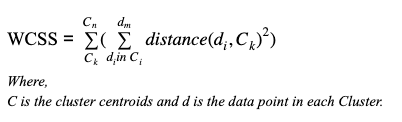

In [163]:
 wcss =[]

 for i in range(1,11):
     kmeans = KMeans(n_clusters=i, init="k-means++", random_state=42)
     kmeans.fit(X)
     wcss.append(kmeans.inertia_)

In [164]:
print(wcss)

[1409820273.195977, 542682733.230944, 317524863.9799874, 195120591.6418579, 136577065.12017953, 98274197.21283984, 74912732.19554454, 59061610.49447939, 48440286.84990534, 40682209.660626665]


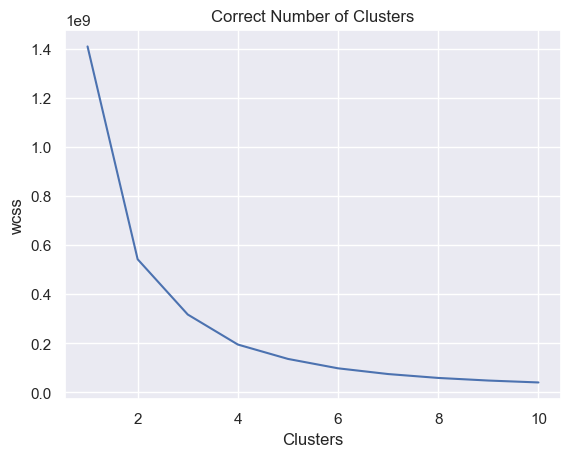

In [165]:
sns.set()
plt.plot(range(1,11),wcss)
plt.title("Correct Number of Clusters")
plt.xlabel("Clusters")
plt.ylabel("wcss")
plt.show()

### Best number of cluster is 4 based on Graph 

### Preliminary training

In [166]:
kmeans = KMeans(n_clusters=4, init="k-means++", random_state=3)
Y = kmeans.fit_predict(X)

In [167]:
X

array([[  36.        ,  479.        ],
       [  35.        ,  491.        ],
       [  64.        , 1446.        ],
       ...,
       [  44.05776177,  645.2350949 ],
       [  40.57387035,  580.671118  ],
       [  43.90018486,  537.629707  ]])

In [168]:
type(X)

numpy.ndarray

In [169]:
Y

array([0, 0, 2, ..., 3, 3, 0], dtype=int32)

In [170]:
type(Y)

numpy.ndarray

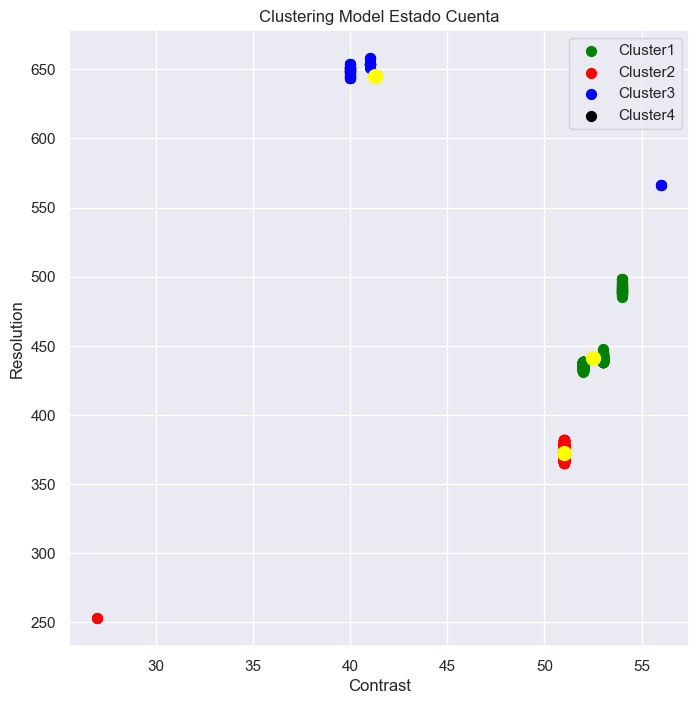

In [206]:
plt.figure(figsize=(8,8))
plt.scatter(X[Y==0, 0], X[Y==0, 1], s=50, c="green", label="Cluster1")
plt.scatter(X[Y==1, 0], X[Y==1, 1], s=50, c="red", label="Cluster2")
plt.scatter(X[Y==2, 0], X[Y==2, 1], s=50, c="blue", label="Cluster3")
plt.scatter(X[Y==3, 0], X[Y==3, 1], s=50, c="black", label="Cluster4")


plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], 
            s=100, c="yellow")

plt.legend()
plt.title("Clustering Model Estado Cuenta")
plt.xlabel("Contrast")
plt.ylabel("Resolution")
plt.show()


The clustering effectively separates the Estado Cuenta data into four distinct groups, with varying patterns in Contrast and Resolution. This suggests meaningful differences in document characteristics, and the clusters can provide valuable insights for further analysis or classification tasks.

## Model- Recibo de Nomina

In [172]:
filt_df_recibo_nomina.head()

,Model,ClassId,PagesProcessed,Fields,EmptyFields,ConfR,ConfA,ConfW,Sharpness,Contrast,Clarity,Resolution,DocType
1,recibo_nomina,NaN,1,15,0,0.948,0.931,0.943,399.0,42.0,17045.0,672.0,IMSS
2,recibo_nomina,NaN,1,15,3,0.941,0.837,0.910,166.0,29.0,4866.0,233.0,IMSS
14,recibo_nomina,NaN,1,15,0,0.973,0.785,0.917,370.0,37.0,14051.0,597.0,IMSS
15,recibo_nomina,NaN,1,15,0,0.973,0.770,0.912,328.0,36.0,11983.0,538.0,IMSS
43,recibo_nomina,NaN,1,15,1,0.969,0.745,0.902,711.0,59.0,42005.0,1071.0,IMSS3


In [173]:
filt_df_recibo_nomina.drop(columns=["Model","ClassId"], inplace=True)
filt_df_recibo_nomina

,PagesProcessed,Fields,EmptyFields,ConfR,ConfA,ConfW,Sharpness,Contrast,Clarity,Resolution,DocType
1,1,15,0,0.948,0.931,0.943,399.000000,42.000000,17045.000000,672.000000,IMSS
2,1,15,3,0.941,0.837,0.910,166.000000,29.000000,4866.000000,233.000000,IMSS
14,1,15,0,0.973,0.785,0.917,370.000000,37.000000,14051.000000,597.000000,IMSS
15,1,15,0,0.973,0.770,0.912,328.000000,36.000000,11983.000000,538.000000,IMSS
43,1,15,1,0.969,0.745,0.902,711.000000,59.000000,42005.000000,1071.000000,IMSS3
...,...,...,...,...,...,...,...,...,...,...,...
62937,1,0,0,0.999,0.799,0.939,126.769108,42.320780,5364.967501,389.118647,ISSSTE
62938,1,0,0,0.999,0.785,0.935,126.069405,42.003501,5295.356420,384.030618,ISSSTE
62950,1,0,0,0.941,0.644,0.852,368.489270,45.789754,16873.033040,301.593351,IMSS
62955,1,0,0,0.999,0.800,0.939,160.990592,43.946808,7075.022648,433.700159,ISSSTE


In [174]:
filt_df_estado_cuenta["DocType"].value_counts()

DocType
EC     26556
APP     4261
SUC     2581
ATM      742
Name: count, dtype: int64

In [175]:
filt_df_recibo_nomina.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10193 entries, 1 to 62956
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   PagesProcessed  10193 non-null  int64  
 1   Fields          10193 non-null  int64  
 2   EmptyFields     10193 non-null  int64  
 3   ConfR           10193 non-null  float64
 4   ConfA           10193 non-null  float64
 5   ConfW           10193 non-null  float64
 6   Sharpness       10193 non-null  float64
 7   Contrast        10193 non-null  float64
 8   Clarity         10193 non-null  float64
 9   Resolution      10193 non-null  float64
 10  DocType         10193 non-null  object 
dtypes: float64(7), int64(3), object(1)
memory usage: 955.6+ KB


### Codification OneHot for categorical columns

In [176]:
df_recibo_nomina_coded = pd.get_dummies(filt_df_recibo_nomina, columns=["DocType"], drop_first=False)
df_recibo_nomina_coded

,PagesProcessed,Fields,EmptyFields,ConfR,ConfA,ConfW,Sharpness,Contrast,Clarity,Resolution,DocType_IMSS,DocType_IMSS3,DocType_ISSSTE,DocType_PEMEX,DocType_SEP
1,1,15,0,0.948,0.931,0.943,399.000000,42.000000,17045.000000,672.000000,True,False,False,False,False
2,1,15,3,0.941,0.837,0.910,166.000000,29.000000,4866.000000,233.000000,True,False,False,False,False
14,1,15,0,0.973,0.785,0.917,370.000000,37.000000,14051.000000,597.000000,True,False,False,False,False
15,1,15,0,0.973,0.770,0.912,328.000000,36.000000,11983.000000,538.000000,True,False,False,False,False
43,1,15,1,0.969,0.745,0.902,711.000000,59.000000,42005.000000,1071.000000,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62937,1,0,0,0.999,0.799,0.939,126.769108,42.320780,5364.967501,389.118647,False,False,True,False,False
62938,1,0,0,0.999,0.785,0.935,126.069405,42.003501,5295.356420,384.030618,False,False,True,False,False
62950,1,0,0,0.941,0.644,0.852,368.489270,45.789754,16873.033040,301.593351,True,False,False,False,False
62955,1,0,0,0.999,0.800,0.939,160.990592,43.946808,7075.022648,433.700159,False,False,True,False,False


In [177]:
df_recibo_nomina_coded.isnull().sum()

PagesProcessed    0
Fields            0
EmptyFields       0
ConfR             0
ConfA             0
ConfW             0
Sharpness         0
Contrast          0
Clarity           0
Resolution        0
DocType_IMSS      0
DocType_IMSS3     0
DocType_ISSSTE    0
DocType_PEMEX     0
DocType_SEP       0
dtype: int64

## Taking Doctype for classification

### X axis - Contrast
### y axis - Resolution

In [178]:
X = df_recibo_nomina_coded.iloc[:,[7,9]].values

In [179]:
 wcss =[]

 for i in range(1,11):
     kmeans = KMeans(n_clusters=i, init="k-means++", random_state=42)
     kmeans.fit(X)
     wcss.append(kmeans.inertia_)

In [180]:
kmeans = KMeans(n_clusters=4, init="k-means++", random_state=3)
Y = kmeans.fit_predict(X)

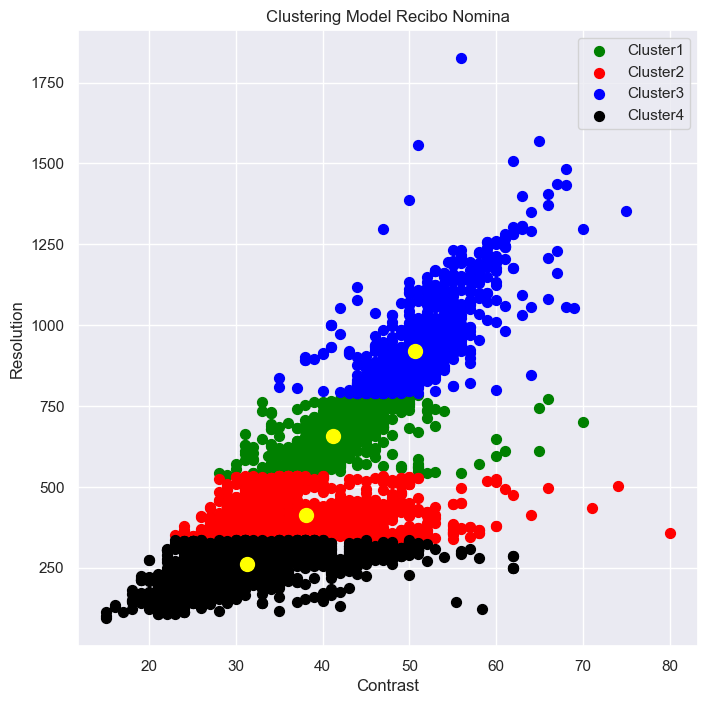

In [181]:
plt.figure(figsize=(8,8))
plt.scatter(X[Y==0, 0], X[Y==0, 1], s=50, c="green", label="Cluster1")
plt.scatter(X[Y==1, 0], X[Y==1, 1], s=50, c="red", label="Cluster2")
plt.scatter(X[Y==2, 0], X[Y==2, 1], s=50, c="blue", label="Cluster3")
plt.scatter(X[Y==3, 0], X[Y==3, 1], s=50, c="black", label="Cluster4")


plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], 
            s=100, c="yellow")

plt.legend()
plt.title("Clustering Model Recibo Nomina")
plt.xlabel("Contrast")
plt.ylabel("Resolution")
plt.show()

The clustering of Recibo Nomina data using Contrast and Resolution reveals four clear groups, indicating meaningful separations in the dataset. The compact clusters and distinct centroids suggest that the k-means model effectively captured the data structure. These results highlight the relevance of the chosen features and provide a basis for further categorization or validation.

## Model- INE

clusters the INE data using the Contrast (X-axis) and Resolution (Y-axis) features with the k-means algorithm. It calculates the WCSS for 1 to 10 clusters to determine the optimal number of clusters and selects 2 clusters (n_clusters=2). The data points are plotted, with each cluster represented by distinct colors (green and red), and the cluster centroids are highlighted in yellow.

In [182]:
filt_df_ine.head()

,Model,ClassId,PagesProcessed,Fields,EmptyFields,ConfR,ConfA,ConfW,Sharpness,Contrast,Clarity,Resolution,DocType
3,ine,NaN,1,38,11,0.914,0.925,0.917,157.0,38.0,6140.0,356.0,INE
7,ine,NaN,1,38,11,0.849,0.873,0.856,174.0,41.0,7275.0,394.0,INE
9,ine,NaN,1,38,11,0.849,0.873,0.856,174.0,41.0,7275.0,394.0,INE
16,ine,NaN,1,38,11,0.834,0.922,0.860,60.0,50.0,3054.0,354.0,INE
22,ine,NaN,1,38,7,0.921,0.912,0.918,92.0,47.0,4423.0,422.0,INE


In [183]:
filt_df_ine.drop(columns=["Model","ClassId"], inplace=True)
filt_df_ine

,PagesProcessed,Fields,EmptyFields,ConfR,ConfA,ConfW,Sharpness,Contrast,Clarity,Resolution,DocType
3,1,38,11,0.914,0.925,0.917,157.000000,38.000000,6140.000000,356.000000,INE
7,1,38,11,0.849,0.873,0.856,174.000000,41.000000,7275.000000,394.000000,INE
9,1,38,11,0.849,0.873,0.856,174.000000,41.000000,7275.000000,394.000000,INE
16,1,38,11,0.834,0.922,0.860,60.000000,50.000000,3054.000000,354.000000,INE
22,1,38,7,0.921,0.912,0.918,92.000000,47.000000,4423.000000,422.000000,INE
...,...,...,...,...,...,...,...,...,...,...,...
62953,1,0,0,0.921,0.898,0.914,16.025871,54.774901,877.815515,292.559381,INE
62954,1,0,0,0.890,0.858,0.880,154.003010,54.145711,8338.602571,748.116796,INE
62957,1,0,0,0.919,0.876,0.906,62.585067,32.024602,2004.261874,207.442956,INE
62958,1,0,0,0.890,0.897,0.892,65.723136,45.672921,3001.767591,570.779433,INE


In [184]:
filt_df_ine["DocType"].value_counts()

DocType
INE     9336
PASS      10
Name: count, dtype: int64

In [185]:
filt_df_ine.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9346 entries, 3 to 62959
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   PagesProcessed  9346 non-null   int64  
 1   Fields          9346 non-null   int64  
 2   EmptyFields     9346 non-null   int64  
 3   ConfR           9346 non-null   float64
 4   ConfA           9346 non-null   float64
 5   ConfW           9346 non-null   float64
 6   Sharpness       9346 non-null   float64
 7   Contrast        9346 non-null   float64
 8   Clarity         9346 non-null   float64
 9   Resolution      9346 non-null   float64
 10  DocType         9346 non-null   object 
dtypes: float64(7), int64(3), object(1)
memory usage: 876.2+ KB


In [186]:
df_ine_coded = pd.get_dummies(filt_df_ine, columns=["DocType"], drop_first=False)
df_ine_coded

,PagesProcessed,Fields,EmptyFields,ConfR,ConfA,ConfW,Sharpness,Contrast,Clarity,Resolution,DocType_INE,DocType_PASS
3,1,38,11,0.914,0.925,0.917,157.000000,38.000000,6140.000000,356.000000,True,False
7,1,38,11,0.849,0.873,0.856,174.000000,41.000000,7275.000000,394.000000,True,False
9,1,38,11,0.849,0.873,0.856,174.000000,41.000000,7275.000000,394.000000,True,False
16,1,38,11,0.834,0.922,0.860,60.000000,50.000000,3054.000000,354.000000,True,False
22,1,38,7,0.921,0.912,0.918,92.000000,47.000000,4423.000000,422.000000,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...
62953,1,0,0,0.921,0.898,0.914,16.025871,54.774901,877.815515,292.559381,True,False
62954,1,0,0,0.890,0.858,0.880,154.003010,54.145711,8338.602571,748.116796,True,False
62957,1,0,0,0.919,0.876,0.906,62.585067,32.024602,2004.261874,207.442956,True,False
62958,1,0,0,0.890,0.897,0.892,65.723136,45.672921,3001.767591,570.779433,True,False


In [187]:
df_ine_coded.isnull().sum()

PagesProcessed    0
Fields            0
EmptyFields       0
ConfR             0
ConfA             0
ConfW             0
Sharpness         0
Contrast          0
Clarity           0
Resolution        0
DocType_INE       0
DocType_PASS      0
dtype: int64

## Taking Doctype for classification

### X axis - Contrast
### y axis - Resolution

In [188]:
 X = df_ine_coded.iloc[:,[7,9]].values
 wcss =[]

 for i in range(1,11):
     kmeans = KMeans(n_clusters=i, init="k-means++", random_state=42)
     kmeans.fit(X)
     wcss.append(kmeans.inertia_)

kmeans = KMeans(n_clusters=2, init="k-means++", random_state=3)
Y = kmeans.fit_predict(X)

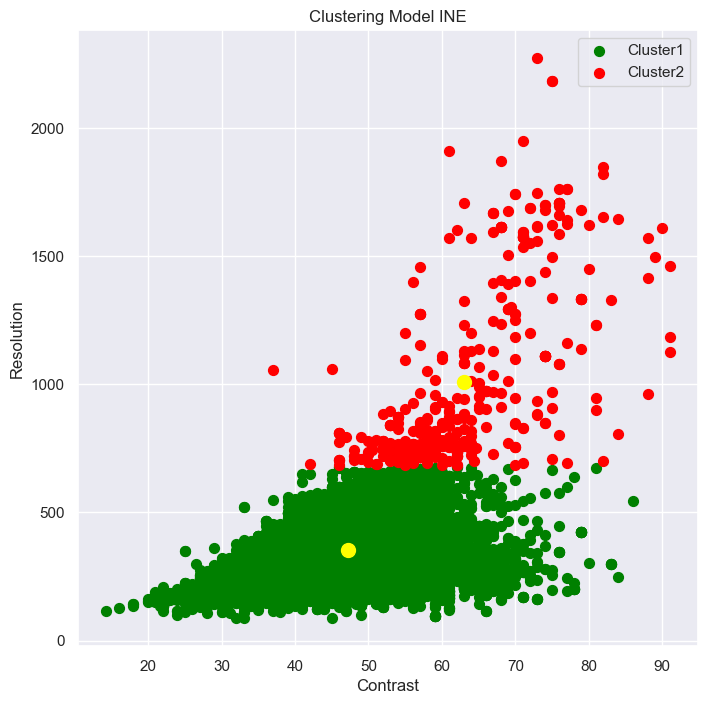

In [189]:
plt.figure(figsize=(8,8))
plt.scatter(X[Y==0, 0], X[Y==0, 1], s=50, c="green", label="Cluster1")
plt.scatter(X[Y==1, 0], X[Y==1, 1], s=50, c="red", label="Cluster2")


plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], 
            s=100, c="yellow")

plt.legend()
plt.title("Clustering Model INE")
plt.xlabel("Contrast")
plt.ylabel("Resolution")
plt.show()

Results shows two distinct groups based on Contrast and Resolution. The clusters are well-separated, indicating clear differences in the data distribution. This separation could provide insights into distinct patterns within the INE data and support further classification or analysis.

## Model- Comprobante de domicilio

In [190]:
filt_df_comprobante_dom.head()

,Model,ClassId,PagesProcessed,Fields,EmptyFields,ConfR,ConfA,ConfW,Sharpness,Contrast,Clarity,Resolution,DocType
0,comprobante_domicilio,NaN,1,12,0,0.981,0.674,0.889,64.0,38.0,2523.0,263.0,CFE
52,comprobante_domicilio,NaN,1,12,0,0.988,0.674,0.894,157.0,32.0,5066.0,340.0,CABLE
85,comprobante_domicilio,NaN,1,12,0,0.999,0.761,0.928,566.0,59.0,33499.0,682.0,CFE
122,comprobante_domicilio,NaN,1,12,0,0.988,0.759,0.919,129.0,40.0,5214.0,302.0,CFE
125,comprobante_domicilio,NaN,1,12,0,0.996,0.763,0.926,104.0,45.0,4755.0,364.0,CFE


In [191]:
filt_df_comprobante_dom.drop(columns=["Model","ClassId"], inplace=True)
filt_df_comprobante_dom

,PagesProcessed,Fields,EmptyFields,ConfR,ConfA,ConfW,Sharpness,Contrast,Clarity,Resolution,DocType
0,1,12,0,0.981,0.674,0.889,64.0,38.0,2523.0,263.0,CFE
52,1,12,0,0.988,0.674,0.894,157.0,32.0,5066.0,340.0,CABLE
85,1,12,0,0.999,0.761,0.928,566.0,59.0,33499.0,682.0,CFE
122,1,12,0,0.988,0.759,0.919,129.0,40.0,5214.0,302.0,CFE
125,1,12,0,0.996,0.763,0.926,104.0,45.0,4755.0,364.0,CFE
...,...,...,...,...,...,...,...,...,...,...,...
61478,1,0,0,0.993,0.794,0.933,117.0,47.0,5577.0,399.0,CFE
61602,1,0,0,0.990,0.728,0.911,130.0,56.0,7378.0,498.0,CFE
61604,1,0,0,0.996,0.808,0.939,170.0,46.0,7907.0,536.0,CFE
61613,1,0,0,0.998,0.689,0.905,97.0,54.0,5350.0,501.0,CFE


In [192]:
filt_df_comprobante_dom.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5780 entries, 0 to 61619
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   PagesProcessed  5780 non-null   int64  
 1   Fields          5780 non-null   int64  
 2   EmptyFields     5780 non-null   int64  
 3   ConfR           5780 non-null   float64
 4   ConfA           5780 non-null   float64
 5   ConfW           5780 non-null   float64
 6   Sharpness       5780 non-null   float64
 7   Contrast        5780 non-null   float64
 8   Clarity         5780 non-null   float64
 9   Resolution      5780 non-null   float64
 10  DocType         5780 non-null   object 
dtypes: float64(7), int64(3), object(1)
memory usage: 541.9+ KB


In [193]:
df_comprobante_dom_coded = pd.get_dummies(filt_df_comprobante_dom, columns=["DocType"], drop_first=False)
df_comprobante_dom_coded

,PagesProcessed,Fields,EmptyFields,ConfR,ConfA,ConfW,Sharpness,Contrast,Clarity,Resolution,DocType_AGUA,DocType_CABLE,DocType_CFE,DocType_CONST,DocType_GAS,DocType_TEL
0,1,12,0,0.981,0.674,0.889,64.0,38.0,2523.0,263.0,False,False,True,False,False,False
52,1,12,0,0.988,0.674,0.894,157.0,32.0,5066.0,340.0,False,True,False,False,False,False
85,1,12,0,0.999,0.761,0.928,566.0,59.0,33499.0,682.0,False,False,True,False,False,False
122,1,12,0,0.988,0.759,0.919,129.0,40.0,5214.0,302.0,False,False,True,False,False,False
125,1,12,0,0.996,0.763,0.926,104.0,45.0,4755.0,364.0,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61478,1,0,0,0.993,0.794,0.933,117.0,47.0,5577.0,399.0,False,False,True,False,False,False
61602,1,0,0,0.990,0.728,0.911,130.0,56.0,7378.0,498.0,False,False,True,False,False,False
61604,1,0,0,0.996,0.808,0.939,170.0,46.0,7907.0,536.0,False,False,True,False,False,False
61613,1,0,0,0.998,0.689,0.905,97.0,54.0,5350.0,501.0,False,False,True,False,False,False


In [194]:
df_comprobante_dom_coded.isnull().sum()

PagesProcessed    0
Fields            0
EmptyFields       0
ConfR             0
ConfA             0
ConfW             0
Sharpness         0
Contrast          0
Clarity           0
Resolution        0
DocType_AGUA      0
DocType_CABLE     0
DocType_CFE       0
DocType_CONST     0
DocType_GAS       0
DocType_TEL       0
dtype: int64

## Taking Doctype for classification

### X axis - Contrast
### y axis - Resolution

processes and clusters the Comprobante de Domicilio dataset using the Contrast (X-axis) and Resolution (Y-axis) features. After dropping irrelevant columns (Model and ClassId), the DocType variable is one-hot encoded, and null values are checked to ensure data consistency. Using the k-means algorithm, the WCSS is calculated for 1 to 10 clusters to determine the optimal number, with 6 clusters selected based on the elbow method. The clusters are visualized in a scatter plot, with each group shown in distinct colors, and their centroids are highlighted in yellow.

In [195]:
 X = df_comprobante_dom_coded.iloc[:,[7,9]].values
 wcss =[]

 for i in range(1,11):
     kmeans = KMeans(n_clusters=i, init="k-means++", random_state=42)
     kmeans.fit(X)
     wcss.append(kmeans.inertia_)

kmeans = KMeans(n_clusters=6, init="k-means++", random_state=3)
Y = kmeans.fit_predict(X)

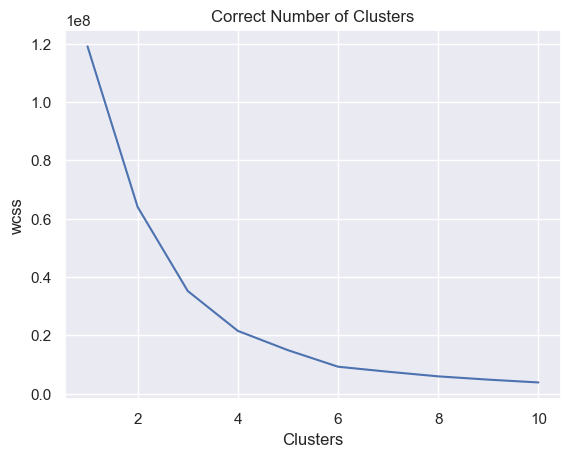

In [196]:
sns.set()
plt.plot(range(1,11),wcss)
plt.title("Correct Number of Clusters")
plt.xlabel("Clusters")
plt.ylabel("wcss")
plt.show()

The clustering reveals six distinct groups based on Contrast and Resolution, indicating clear separations in the dataset. This clustering can be used to analyze patterns or similarities within the Comprobante de Domicilio data, providing meaningful insights for classification or further analysis.

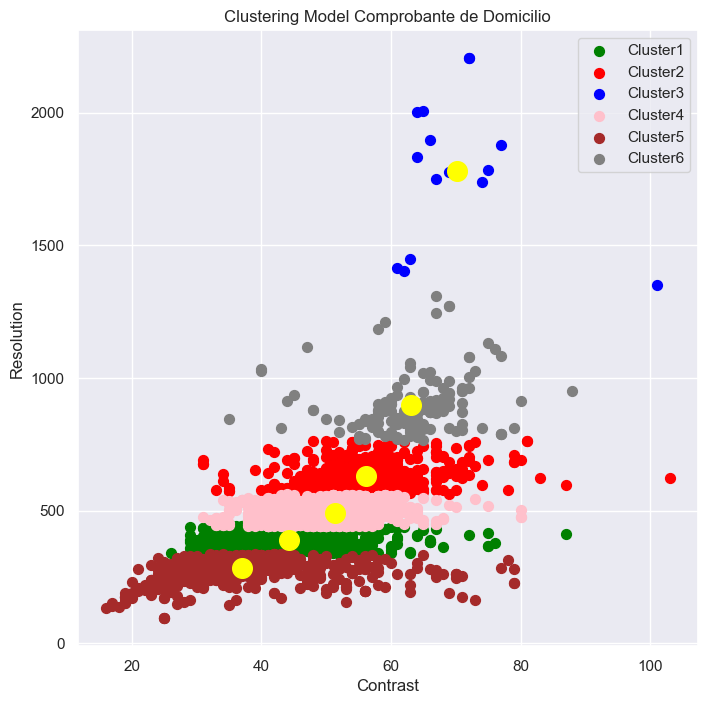

In [197]:
plt.figure(figsize=(8,8))


plt.scatter(X[Y == 0, 0], X[Y == 0, 1], s=50, c="green", label="Cluster1")
plt.scatter(X[Y == 1, 0], X[Y == 1, 1], s=50, c="red", label="Cluster2")
plt.scatter(X[Y == 2, 0], X[Y == 2, 1], s=50, c="blue", label="Cluster3")
plt.scatter(X[Y == 3, 0], X[Y == 3, 1], s=50, c="pink", label="Cluster4")
plt.scatter(X[Y == 4, 0], X[Y == 4, 1], s=50, c="brown", label="Cluster5")
plt.scatter(X[Y == 5, 0], X[Y == 5, 1], s=50, c="gray", label="Cluster6")  


plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], 
            s=200, c="yellow")

plt.legend()
plt.title("Clustering Model Comprobante de Domicilio")
plt.xlabel("Contrast")
plt.ylabel("Resolution")
plt.show()

## Model- Carta Libranza

Processes the Carta Libranza dataset to cluster data points using Contrast (X-axis) and Resolution (Y-axis). After preparing the data by dropping irrelevant columns (Model and ClassId) and one-hot encoding DocType, the k-means algorithm is applied. The WCSS is calculated for 1 to 10 clusters to determine the optimal number of clusters, and based on the elbow method, 3 clusters are chosen. The clusters are visualized, with each group represented by distinct colors, and the centroids are highlighted in yellow

In [198]:
filt_df_carta_lib.head()

,Model,ClassId,PagesProcessed,Fields,EmptyFields,ConfR,ConfA,ConfW,Sharpness,Contrast,Clarity,Resolution,DocType
6,carta_libranza,NaN,1,19,0,0.993,0.975,0.987,1137.0,51.0,58551.0,376.0,CLIB
8,carta_libranza,NaN,1,19,0,0.993,0.975,0.988,1137.0,51.0,58551.0,376.0,CLIB
21,carta_libranza,NaN,1,19,0,0.995,0.978,0.990,1127.0,51.0,57854.0,371.0,CLIB
23,carta_libranza,NaN,1,19,0,0.996,0.976,0.990,1131.0,51.0,58111.0,373.0,CLIB
25,carta_libranza,NaN,1,19,0,0.999,0.943,0.982,1487.0,54.0,80796.0,493.0,CLIB


In [199]:
filt_df_carta_lib.drop(columns=["Model","ClassId"], inplace=True)
filt_df_carta_lib

,PagesProcessed,Fields,EmptyFields,ConfR,ConfA,ConfW,Sharpness,Contrast,Clarity,Resolution,DocType
6,1,19,0,0.993,0.975,0.987,1137.0,51.0,58551.0,376.0,CLIB
8,1,19,0,0.993,0.975,0.988,1137.0,51.0,58551.0,376.0,CLIB
21,1,19,0,0.995,0.978,0.990,1127.0,51.0,57854.0,371.0,CLIB
23,1,19,0,0.996,0.976,0.990,1131.0,51.0,58111.0,373.0,CLIB
25,1,19,0,0.999,0.943,0.982,1487.0,54.0,80796.0,493.0,CLIB
...,...,...,...,...,...,...,...,...,...,...,...
61593,1,0,0,0.999,0.963,0.988,1319.0,52.0,69890.0,437.0,CLIB
61595,1,0,0,0.999,0.962,0.988,1331.0,53.0,70704.0,441.0,CLIB
61597,1,0,0,0.995,0.965,0.986,1124.0,51.0,57717.0,371.0,CLIB
61599,1,0,0,0.990,0.961,0.981,1115.0,51.0,57117.0,369.0,CLIB


In [200]:
filt_df_carta_lib.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3501 entries, 6 to 61601
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   PagesProcessed  3501 non-null   int64  
 1   Fields          3501 non-null   int64  
 2   EmptyFields     3501 non-null   int64  
 3   ConfR           3501 non-null   float64
 4   ConfA           3501 non-null   float64
 5   ConfW           3501 non-null   float64
 6   Sharpness       3501 non-null   float64
 7   Contrast        3501 non-null   float64
 8   Clarity         3501 non-null   float64
 9   Resolution      3501 non-null   float64
 10  DocType         3501 non-null   object 
dtypes: float64(7), int64(3), object(1)
memory usage: 328.2+ KB


In [201]:
df_carta_lib_coded = pd.get_dummies(filt_df_carta_lib, columns=["DocType"], drop_first=False)
df_carta_lib_coded

,PagesProcessed,Fields,EmptyFields,ConfR,ConfA,ConfW,Sharpness,Contrast,Clarity,Resolution,DocType_CLIB
6,1,19,0,0.993,0.975,0.987,1137.0,51.0,58551.0,376.0,True
8,1,19,0,0.993,0.975,0.988,1137.0,51.0,58551.0,376.0,True
21,1,19,0,0.995,0.978,0.990,1127.0,51.0,57854.0,371.0,True
23,1,19,0,0.996,0.976,0.990,1131.0,51.0,58111.0,373.0,True
25,1,19,0,0.999,0.943,0.982,1487.0,54.0,80796.0,493.0,True
...,...,...,...,...,...,...,...,...,...,...,...
61593,1,0,0,0.999,0.963,0.988,1319.0,52.0,69890.0,437.0,True
61595,1,0,0,0.999,0.962,0.988,1331.0,53.0,70704.0,441.0,True
61597,1,0,0,0.995,0.965,0.986,1124.0,51.0,57717.0,371.0,True
61599,1,0,0,0.990,0.961,0.981,1115.0,51.0,57117.0,369.0,True


## Taking Doctype for classification

### X axis - Contrast
### y axis - Resolution

In [202]:
 X = df_carta_lib_coded.iloc[:,[7,9]].values
 wcss =[]

 for i in range(1,11):
     kmeans = KMeans(n_clusters=i, init="k-means++", random_state=42)
     kmeans.fit(X)
     wcss.append(kmeans.inertia_)

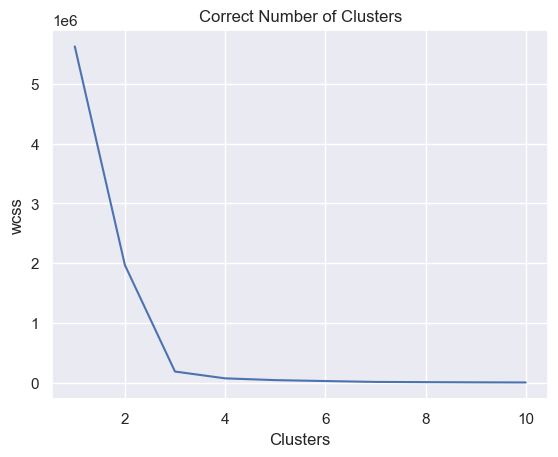

In [203]:
sns.set()
plt.plot(range(1,11),wcss)
plt.title("Correct Number of Clusters")
plt.xlabel("Clusters")
plt.ylabel("wcss")
plt.show()

In [204]:
kmeans = KMeans(n_clusters=3, init="k-means++", random_state=3)
Y = kmeans.fit_predict(X)

The clustering for Carta Libranza reveals three distinct groups, showing clear separations in the dataset based on Contrast and Resolution. This clustering approach effectively identifies patterns within the data, providing meaningful insights for further classification or analysis. The elbow method validates the selection of 3 clusters as optimal

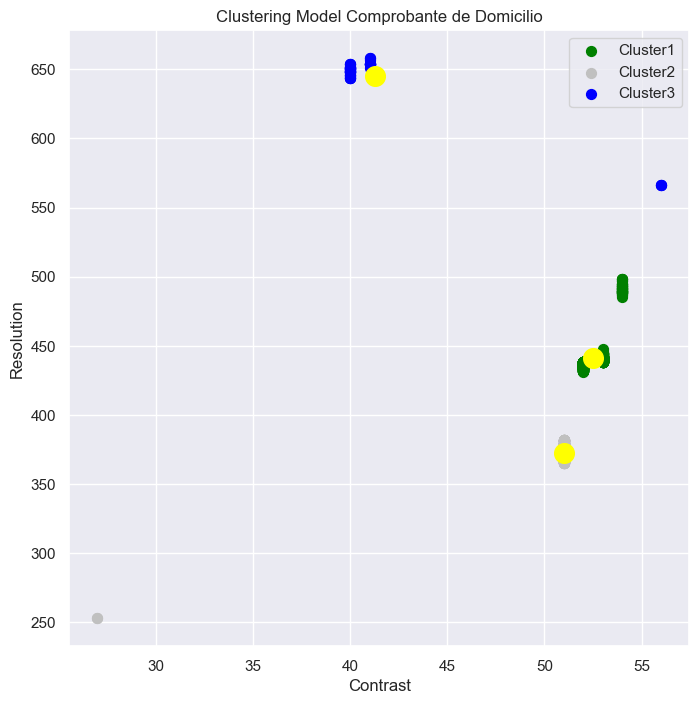

In [205]:
plt.figure(figsize=(8,8))


plt.scatter(X[Y == 0, 0], X[Y == 0, 1], s=50, c="green", label="Cluster1")
plt.scatter(X[Y == 1, 0], X[Y == 1, 1], s=50, c="silver", label="Cluster2")
plt.scatter(X[Y == 2, 0], X[Y == 2, 1], s=50, c="blue", label="Cluster3")



plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], 
            s=200, c="yellow")

plt.legend()
plt.title("Clustering Model Comprobante de Domicilio")
plt.xlabel("Contrast")
plt.ylabel("Resolution")
plt.show()

## Conclusions

- **No Missing Values**:  
  The dataframe does not contain any missing values, so no additional data imputation was necessary during the process.

- **Outliers and PCA**:  
  The data analysis verified that the information in the dataframe does not contain significant outliers. After applying Principal Component Analysis (PCA) on the entire dataframe, we found that the current columns explain more than 80% of the variation in our model. This analysis is documented in the `FE_transformation.ipynb` file located in this folder.

- **Categorical Data Encoding**:  
  Since we are applying clustering, One-Hot Encoding was chosen for categorical variables, as it has shown good results when used in conjunction with clustering algorithms.

- **WCSS for Clustering**:  
  While WCSS (Within-Cluster Sum of Squares) is not listed as a recommended feature engineering method for this activity, it played a crucial role in ensuring that the number of clusters chosen for each model was the most optimal.

- **KMeans Clustering Implementation**:  
  We started implementing model training based on KMeans clustering to assess the cluster performance across our models. The results so far are promising in terms of correct distributions, but there are still a few aspects that need to be confirmed with our tutor. Some of the questions we intend to discuss include:
  
    1. Our preliminary clustering analysis using KMeans shows good results, but we are only plotting two variables (Resolution and Contrast) for all models. Is it necessary to demonstrate clustering performance with additional variables?
    
    2. Besides KMeans, are there other clustering methods you would recommend exploring to further differentiate the performance of the models?
